In [119]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer, normalize, PolynomialFeatures

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, RandomOverSampler


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('abalone.data', names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'])
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


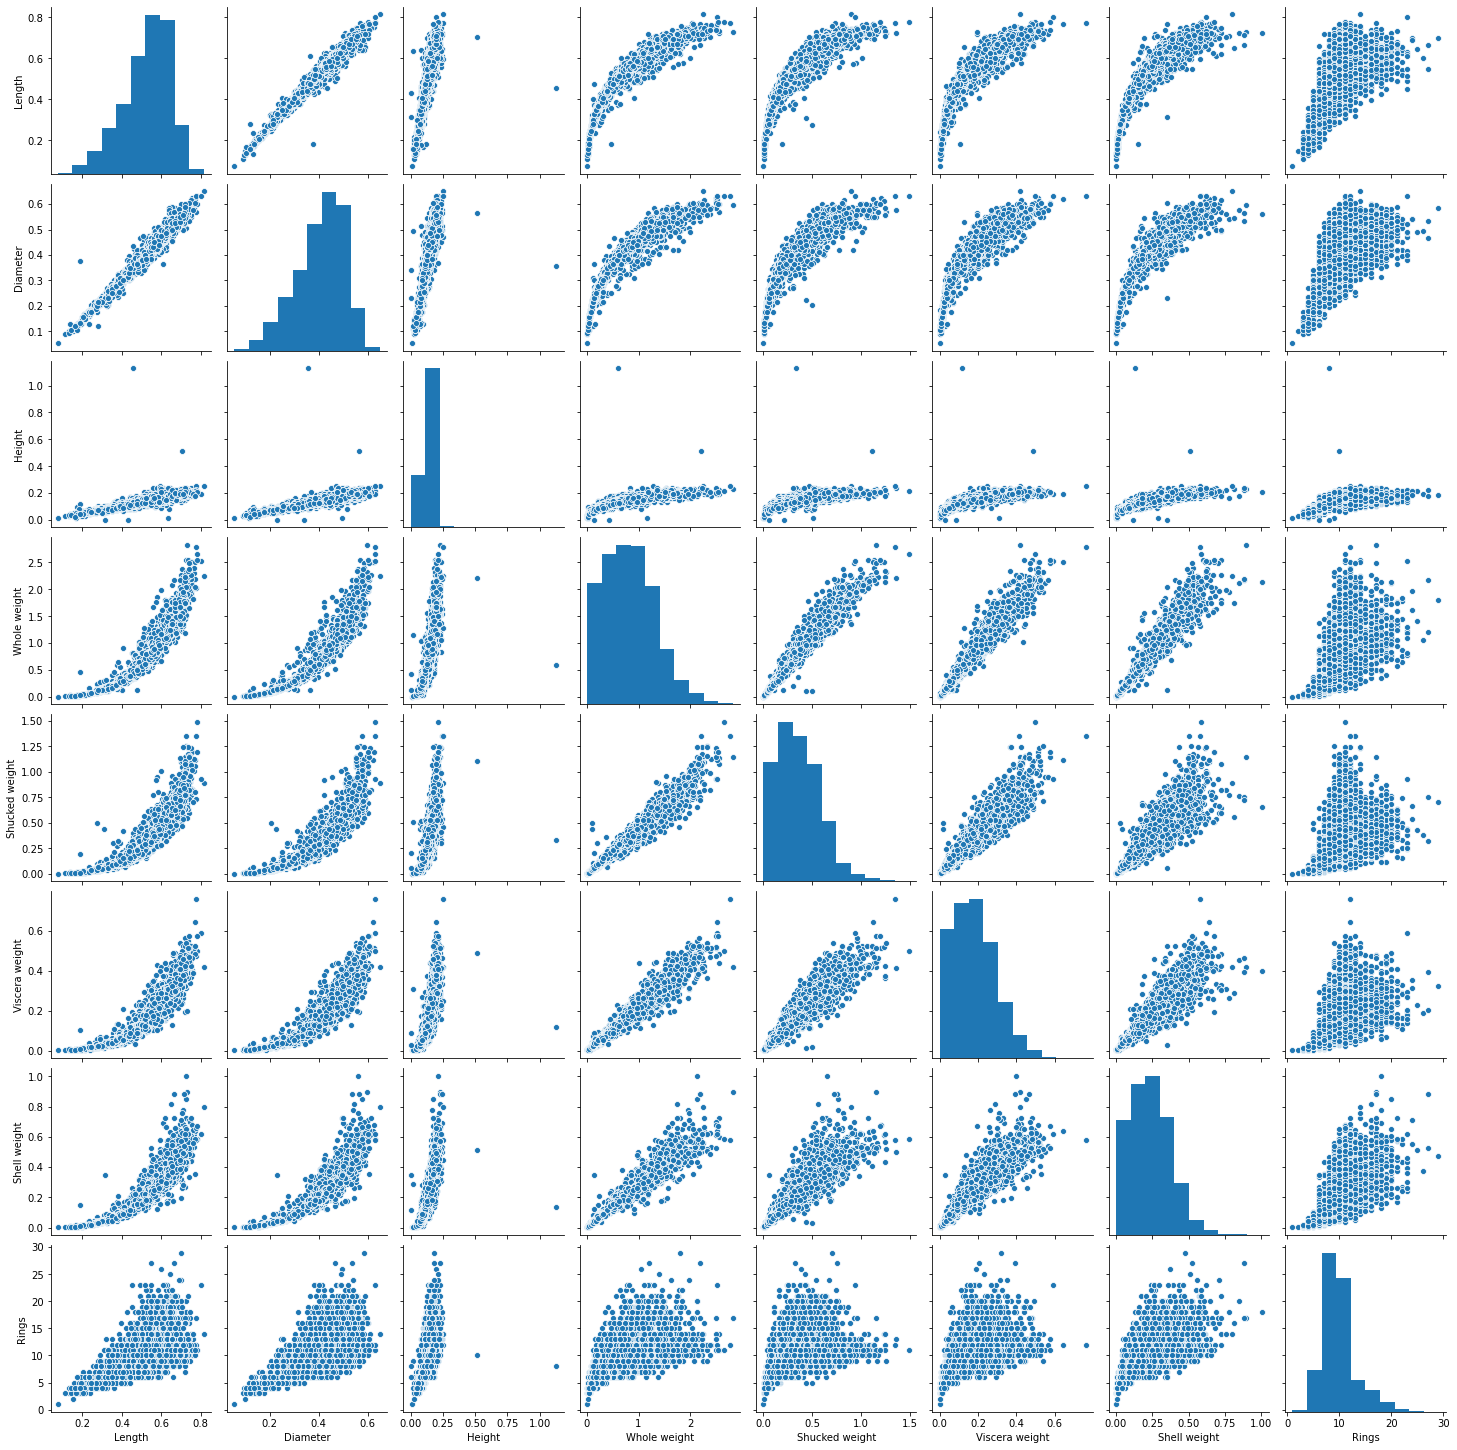

In [4]:
sns.pairplot(df)

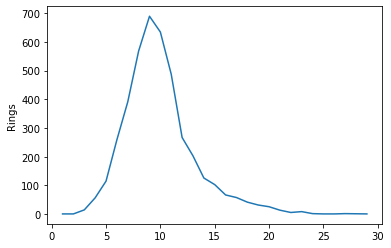

In [5]:
sns.lineplot(y = df['Rings'].value_counts(), x = df['Rings'].value_counts().index)

# OneHotEncoder

In [6]:
df['Sex'].value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

In [7]:
onehotenc_sex = pd.get_dummies(df['Sex'])
df.insert(1, onehotenc_sex.columns[0], onehotenc_sex.iloc[:, 0])
df.insert(1, onehotenc_sex.columns[1], onehotenc_sex.iloc[:, 1])
df.insert(1, onehotenc_sex.columns[2], onehotenc_sex.iloc[:, 2])
df

,Sex,M,I,F,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,1,0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,1,0,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0,0,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,1,0,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0,1,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...,...,...
4172,F,0,0,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,1,0,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,1,0,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0,0,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [8]:
df.groupby('Length')['Rings'].describe()

,count,mean,std,min,25%,50%,75%,max
Length,,,,,,,,
0.075,1.0,1.0,NaN,1.0,1.00,1.0,1.00,1.0
0.110,1.0,3.0,NaN,3.0,3.00,3.0,3.00,3.0
0.130,2.0,3.5,0.707107,3.0,3.25,3.5,3.75,4.0
0.135,1.0,4.0,NaN,4.0,4.00,4.0,4.00,4.0
0.140,2.0,3.5,0.707107,3.0,3.25,3.5,3.75,4.0
...,...,...,...,...,...,...,...,...
0.770,3.0,11.0,1.000000,10.0,10.50,11.0,11.50,12.0
0.775,2.0,14.5,3.535534,12.0,13.25,14.5,15.75,17.0
0.780,2.0,11.0,0.000000,11.0,11.00,11.0,11.00,11.0


# Models

In [9]:
X = df.drop(['Sex', 'Rings'], axis = 1)
Y = df['Rings']

#### Feature engineering

In [10]:
maj_classes = Y.value_counts()[Y.value_counts()>10].index
Y.value_counts()

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
24      2
27      2
1       1
25      1
2       1
26      1
29      1
Name: Rings, dtype: int64

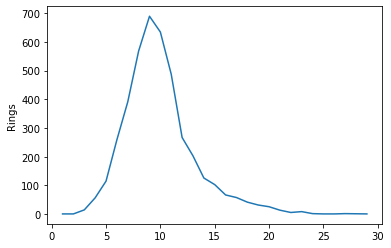

In [11]:
sns.lineplot(x = Y.value_counts().index, y = Y.value_counts())

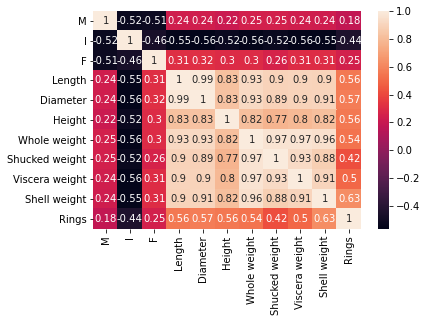

In [12]:
sns.heatmap(df.corr(), annot = True)

In [13]:
relevant_features = df.corr()['Rings'][abs(df.corr()['Rings']) > 0.5].index.drop('Rings')
selected_features = ['Shell weight', 'Height']

In [36]:
# X = X[selected_features]
# X = X[['Height', 'Shell weight']]

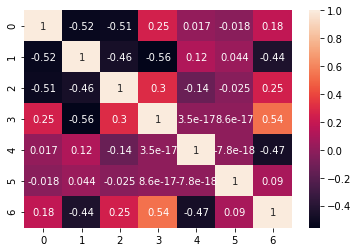

In [14]:
X = df.drop(['Sex', 'Rings'], axis = 1)
Y = df['Rings']
X_y = np.hstack([X.iloc[:, :3], PCA(n_components = 3).fit_transform(X.iloc[:, 3:]), Y.to_numpy().reshape([-1, 1])])
sns.heatmap(pd.DataFrame(X_y).corr(), annot = True)

#### Models

In [111]:
# обробка

# X = PolynomialFeatures(degree = 2).fit_transform(X)
# scalers:
# X = StandardScaler().fit(X).transform(X)
# X = QuantileTransformer().fit(X).transform(X)
# X = normalize(X)

# зменшення розмірності
# X = PCA(n_components = 3).fit_transform(X.iloc[:, 3:])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

# обробка класів
#   видалення мінорних класів
# maj_index = y_train.isin(maj_classes)
# y_train = y_train[maj_index]
# X_train = X_train[maj_index]

#  oversampling
# X_train, y_train = RandomOverSampler(random_state = 1).fit_resample(X_train, y_train)
# X_train, y_train = SMOTE(k_neighbors = 3).fit_resample(X_train, y_train)


KNC_model = KNeighborsClassifier(n_neighbors = 30)
KNC_model_f = KNC_model.fit(X_train, y_train)

Centroid_model = NearestCentroid()
Centroid_model_f = Centroid_model.fit(X_train, y_train)

L_model = LinearRegression().fit(X_train, y_train)

SVC_model = SVC()

print(f'KNC score: {KNC_model_f.score(X_test, y_test)}')
print(f'KNC cross val score: {cross_val_score(KNC_model, X, Y).mean()}')
print(f'\nCentroid score: {Centroid_model_f.score(X_test, y_test)}')
print(f'Centroid cross val score: {cross_val_score(Centroid_model, X, Y).mean()}')
print(f'\nLinear regression score: {accuracy_score(np.round(L_model.predict(X_test)), y_test)}')
print(f'\nSVM cross val score: {cross_val_score(SVC_model, X, Y).mean()}')

KNC score: 0.25478468899521534
KNC cross val score: 0.2690977852906627

Centroid score: 0.05980861244019139
Centroid cross val score: 0.05386127266997106

Linear regression score: 0.22488038277511962

SVM cross val score: 0.2576056499441309


### Stacking

##### (власні спроби)

In [17]:
df2 = df.copy()

In [18]:
# поділ на 3 групи
map_rings = dict.fromkeys([i for i in range(9)], 1)
map_rings.update(dict.fromkeys([9, 10], 2))
map_rings.update(dict.fromkeys([i for i in range(11, 30)], 3))

df2.insert(11, 'rings group', df2['Rings'].map(map_rings))

In [19]:
print(df2['rings group'].value_counts())
df2.head()

3    1447
1    1407
2    1323
Name: rings group, dtype: int64


,Sex,M,I,F,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,rings group,Rings
0,M,1,0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,3,15
1,M,1,0,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,7
2,F,0,0,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,2,9
3,M,1,0,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,2,10
4,I,0,1,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,1,7


In [138]:
# створення навчальних вибірок з групою "rings group" та без неї
X = df2.drop(['Sex', 'Rings', 'rings group'], axis = 1)
Y2 = df2['rings group']
# X_groups = df2.drop(['Sex', 'Rings'], axis = 1)
X_groups = df2[['Shell weight', 'rings group']]
Y_main = df2['Rings']



X_train, X_test, Y2_train, Y2_test = train_test_split(X, Y2, train_size = 0.8, random_state = 1)
X_g_train, X_g_test, Y_m_train, Y_m_test = train_test_split(X_groups, Y_main, train_size = 0.8, random_state = 1)

KNC_model = KNeighborsClassifier(n_neighbors = 30)
KNC_groups = KNC_model.fit(X_train, Y2_train)
KNC_main = KNeighborsClassifier(n_neighbors = 30).fit(X_g_train, Y_m_train)

L_model_groups = LinearRegression().fit(X_train, Y2_train)
L_model = LinearRegression().fit(X_g_train, Y_m_train)

#додаємо до тестової вибірки передбачені моделлю KNC_groups класу "rings group"
X_g_test['rings group'] = KNC_groups.predict(X_test)



print(f'cross val score for groups: {cross_val_score(KNC, X, Y2).mean()}')
print(f'Linear regression for groups: {accuracy_score(np.round(L_model_groups.predict(X_test)), Y2_test)}')

print(f'\nKNeighborsClassifier score: {KNC_main.score(X_g_test, Y_m_test)}')

print(f'Linear regression score: {accuracy_score(np.round(L_model.predict(X_g_test)), Y_m_test)}')




cross val score for groups: 0.6315563132108988
Linear regression for groups: 0.5849282296650717

KNeighborsClassifier score: 0.2583732057416268
Linear regression score: 0.2021531100478469


### Sclearn stacking

In [127]:
X = df2.drop(['Sex', 'Rings', 'rings group'], axis = 1)
Y = df['Rings']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1)

estimators = [
    ('KNC', KNeighborsClassifier(n_neighbors = 30)),
    ('NC', NearestCentroid()),
    ('SVC', SVC()),
    ('LR', LogisticRegression())
] 

clf = StackingClassifier(estimators = estimators, final_estimator = KNeighborsClassifier(n_neighbors = 30))

clf.fit(X_train, Y_train).score(X_test, Y_test)

0.22248803827751196